# Clustering de datos

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
from functools import reduce

project_path = os.path.abspath('../..')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tslearn as ts

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KernelKMeans
from tslearn.utils import to_time_series_dataset

import seaborn as sns
sns.set(style="darkgrid")

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.visualization.clustering import *
from src.models.clustering import bench_k_means

/home/agonzalez/miniconda3/envs/mds7202/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


## Torreo meteorológica de CODELCO

### Carga de datos 

In [2]:
meteo_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'Torre Meteo Codelco Ventanas.xlsx')#.set_index('date')

In [3]:
meteo_df['T_dif'] = meteo_df['T_40'] - meteo_df['T_10']
meteo_df['WD_dif'] = meteo_df['WD_40'] - meteo_df['WD_10']
meteo_df['WS_dif'] = meteo_df['WS_40'] - meteo_df['WS_10']
meteo_df['SigDir_dif'] = meteo_df['SigDir_40'] - meteo_df['SigDir_10']
meteo_df['HR_dif'] = meteo_df['HR_40'] - meteo_df['HR_10']

meteo_df = meteo_df[['date'] + meteo_df.columns[-5:].tolist()]
meteo_df.set_index('date', inplace=True)
# meteo_df.dropna(inplace=True)

In [4]:
meteo_df.head()

,T_dif,WD_dif,WS_dif,SigDir_dif,HR_dif
date,,,,,
2017-01-01 01:00:00,0.2768,2.7303,-0.35788,20.98000,-6.2247
2017-01-01 02:00:00,0.3665,-0.0120,-1.02448,37.48000,-6.1518
2017-01-01 03:00:00,0.5527,-29.6691,0.76479,10.35800,-5.0900
2017-01-01 04:00:00,0.8930,-43.4263,0.58976,0.69000,-5.2384
2017-01-01 05:00:00,0.7969,-39.7236,0.02338,8.15001,-5.0584


In [275]:
def get_dates_with(df, col, level, condition='geq'):
    if condition == 'geq':
        passed_limits = df.loc[df[col] < level]
    else:
        passed_limits = df.loc[df[col] > level]
    dates = np.unique(passed_limits.index.date)
    mask_to_drop = [date not in dates for date in df.index.date]
    return df.loc[mask_to_drop], dates

In [286]:
quintero_df = get_minma_data(['SO2'], 'quintero', from_last='140w')
quintero_df = quintero_df.filter(regex='Registros no validados.*')

quintero_df = quintero_df.rename({'Registros no validados_SO2':'SO2'},axis=1)

In [287]:
quintero_df, dropped_dates = get_dates_with(quintero_df, 'SO2', 50, 'geq')

0


In [176]:
np.unique(quintero_df.index.date)

array([], dtype=object)

In [ ]:
get_dates_with(fd, '')

In [51]:
df = pd.read_csv('quintero_peaks.csv',index_col=1)

In [52]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [59]:
df.index = pd.to_datetime(df.index)

In [101]:
from sklearn.model_selection import train_test_split

### Formateo para tslearn

In [36]:
df.index = pd.to_datetime(df.index)

In [80]:
asd = pd.Series([])

/tmp/ipykernel_282/3044168762.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  asd = pd.Series([])


In [84]:
meteo_daily = [g for n, g in df['SO2'].groupby(pd.Grouper(freq='D')) if not g.empty]

# meteo_daily_T = [g.values for n, g in meteo_df.loc['2017',['T_dif']].groupby(pd.Grouper(freq='D'))]
# meteo_daily_HR = [g.values for n, g in meteo_df.loc['2017',['HR_dif']].groupby(pd.Grouper(freq='D'))]

X_train = to_time_series_dataset(meteo_daily)
X_train = np.nan_to_num(X_train)

In [ ]:
from tslearn.metrics import dtw
cost = dtw(x, y, global_constraint="itakura", itakura_max_slope=2.)

### Benchmarking con distinto n de clústers

In [114]:
seed = 42 
np.random.seed(seed)

dtw_inertia_list = []
gak_inertia_list = []
n_clusters = np.arange(2,10)

print('init\t\tn_clusters\ttime\tinertia\t\tsilhouette')
print(70 * '_')

for n in n_clusters:

    dtw_km = TimeSeriesKMeans(n_clusters=n,
                              n_init=5,
                              metric="dtw",
                              max_iter_barycenter=50,
                              random_state=seed)

    _, _, dtw_inertia = bench_k_means(kmeans=dtw_km, name="dtw", data=X_train, n_clusters=n)
    dtw_inertia_list.append(dtw_inertia)

    gak_km = KernelKMeans(n_clusters=n,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      random_state=seed)

    _, _, gak_inertia = bench_k_means(kmeans=gak_km, name="gak", data=X_train, n_clusters=n)
    gak_inertia_list.append(gak_inertia)

print(70 * '_')

init		n_clusters	time	inertia		silhouette
______________________________________________________________________
dtw      		2	0.401	0.238		0.130
gak      		2	0.490	58.302		0.015
dtw      		3	0.421	0.184		0.035
gak      		3	0.053	56.010		0.012
dtw      		4	0.432	0.152		0.039
gak      		4	0.054	54.791		-0.027
dtw      		5	0.482	0.128		0.009
gak      		5	0.058	43.430		0.035
dtw      		6	0.589	0.107		0.018
gak      		6	0.057	43.929		0.020
dtw      		7	0.544	0.093		-0.021
gak      		7	0.057	45.833		-0.087
dtw      		8	0.632	0.076		-0.045
gak      		8	0.055	43.860		-0.093
dtw      		9	0.889	0.066		-0.073
gak      		9	0.059	39.402		-0.109
______________________________________________________________________


### Método del codo

#### DTW

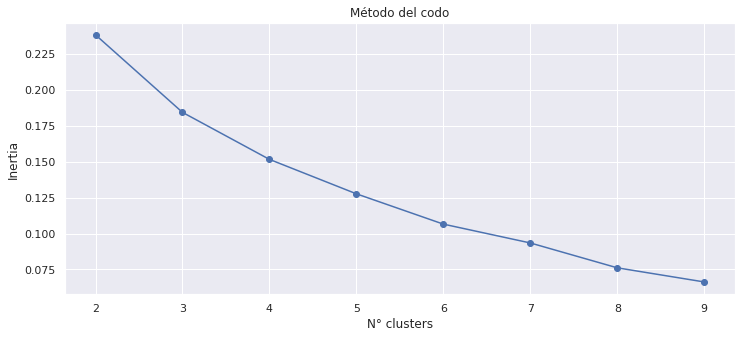

In [115]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, dtw_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

#### GAK

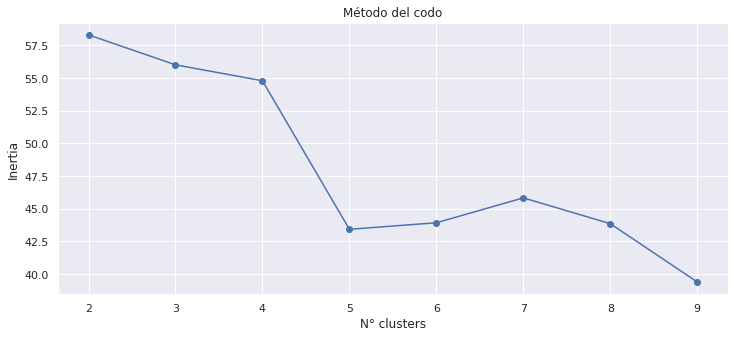

In [116]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, gak_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

### Mejor modelo

In [122]:
seed = 42 
np.random.seed(seed)

dba_km = TimeSeriesKMeans(n_clusters=5,
                          n_init=2,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)

_, y_pred, _ = bench_k_means(kmeans=dba_km, name="dba_minmax", data=X_train, n_clusters=2)

dba_minmax		2	0.169	0.136		0.009


### Centros de clústers

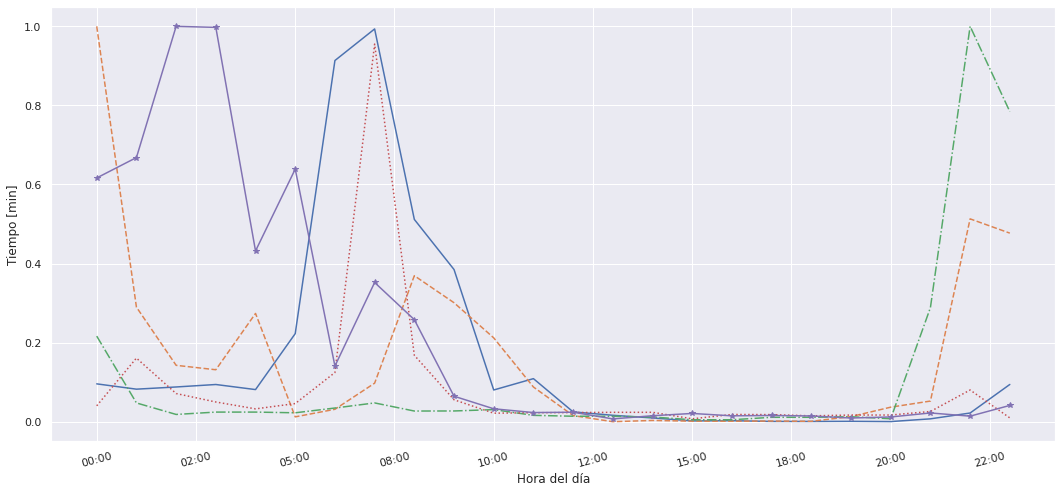

In [123]:
plot_cluster_centers(dba_km.cluster_centers_, ['asd','ewq', 'qwe','qwe', 'qwe'], "Tiempo [min]")


### Distribución de clústers

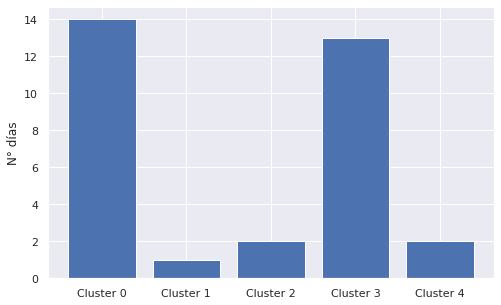

In [124]:
fig, axs = plt.subplots(figsize=(8,5))

cluster_distribution(y_pred)

plt.show()

In [109]:
X_train, X_val_test = train_test_split(X_train,  test_size=0.30, random_state=42)
X_val, X_test = train_test_split(X_val_test,  test_size=0.5, random_state=42)

### Visualización de clústers

In [127]:
from tslearn.metrics import dtw
cost = dtw(X_val[0], dba_km.cluster_centers_[0], global_constraint="itakura", itakura_max_slope=2.)

In [155]:
X_val = (X_val - X_val.mean()) / X_val.std()

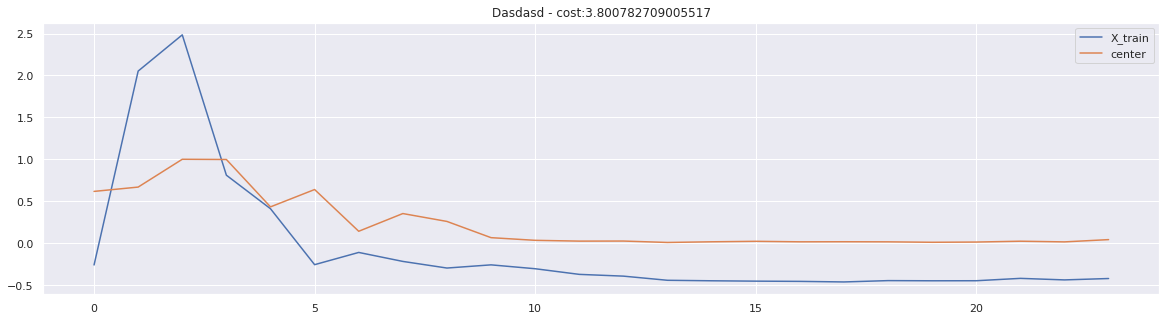

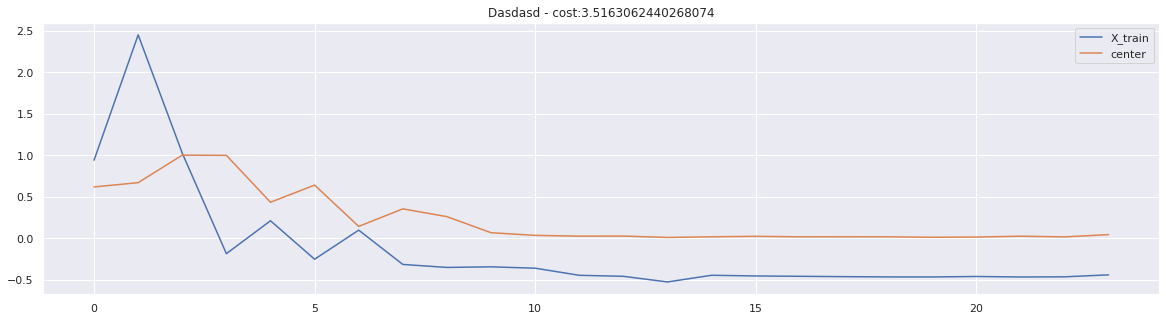

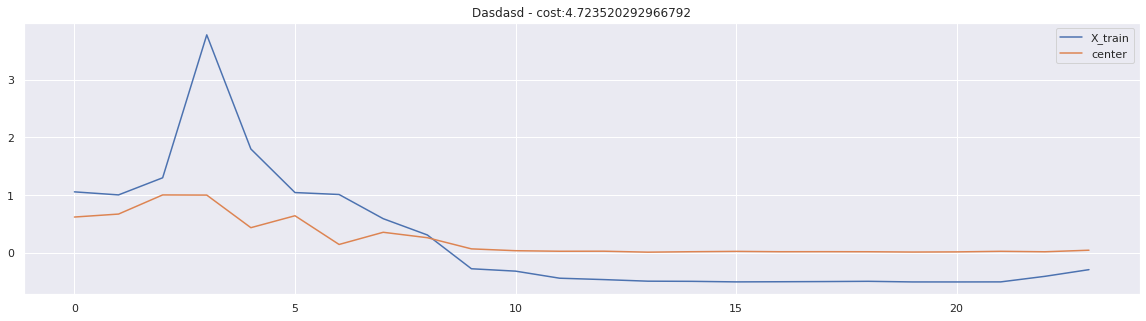

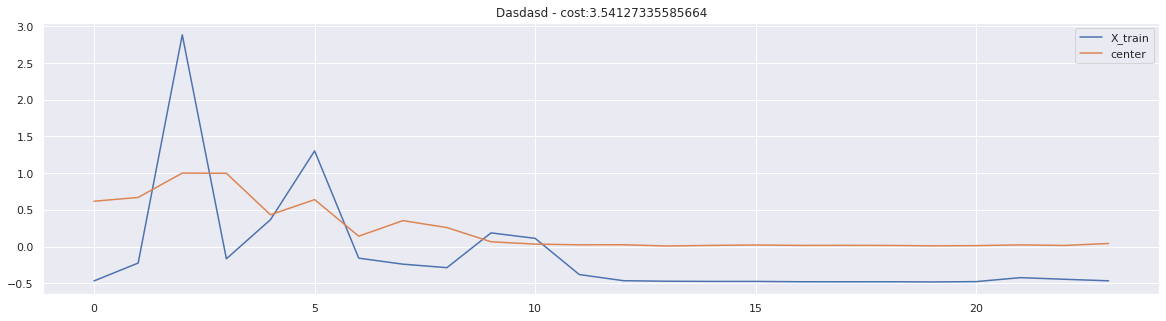

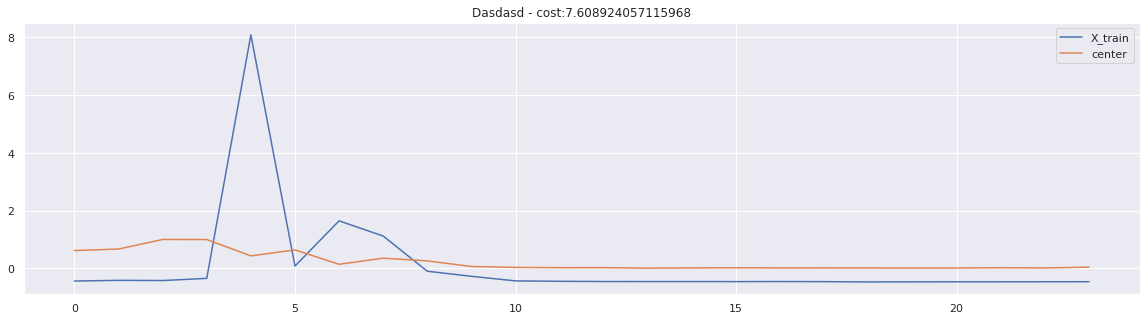

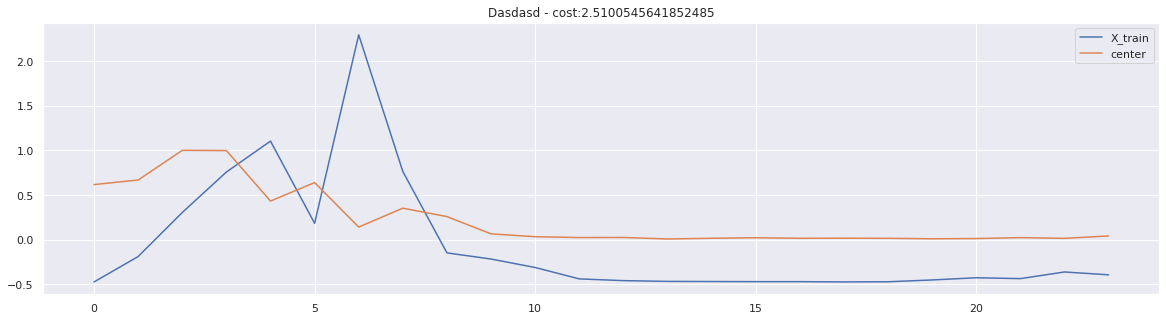

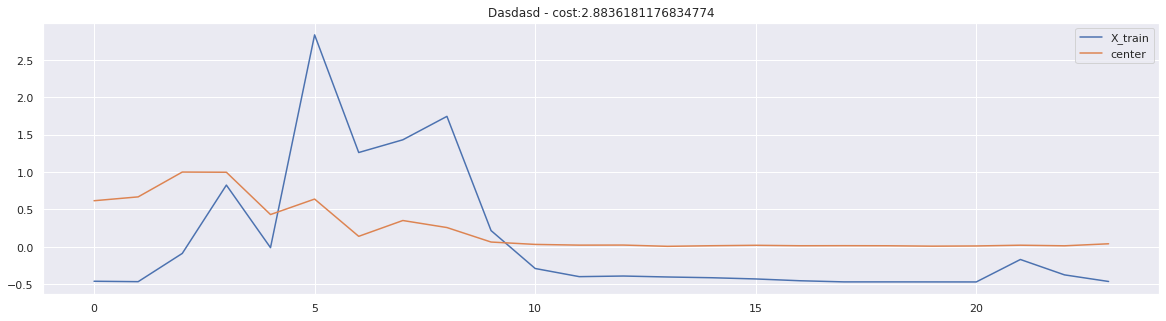

In [156]:
for idx in range(7):
    # idx = 4

    fig, ax = plt.subplots(figsize=(20,5))

    cost = dtw(X_val[idx], dba_km.cluster_centers_[0], global_constraint="itakura", itakura_max_slope=2.)
    plt.plot(X_val[idx])
    plt.plot(dba_km.cluster_centers_[4])
    ax.set_title(f'Dasdasd - cost:{cost}')
    ax.legend(['X_train', 'center'])

In [131]:
for idx, center in enumerate(dba_km.cluster_centers_):
    cost = dtw(X_val[0], center, global_constraint="itakura", itakura_max_slope=2.)
    print(cost)

211.48363432366318
211.36293420648832
211.8134245863971
211.57876537168138
210.1029859635277


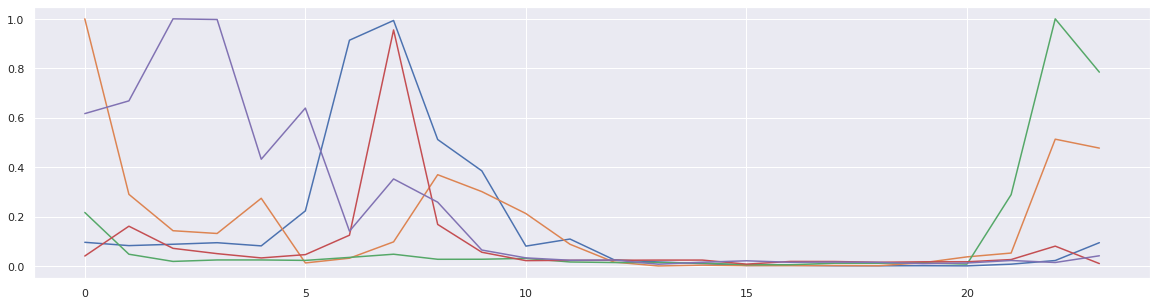

In [125]:
fig, ax = plt.subplots(figsize=(20,5))

for i in range(5):
    ax.plot(dba_km.cluster_centers_[i])

IndexError: list index out of range

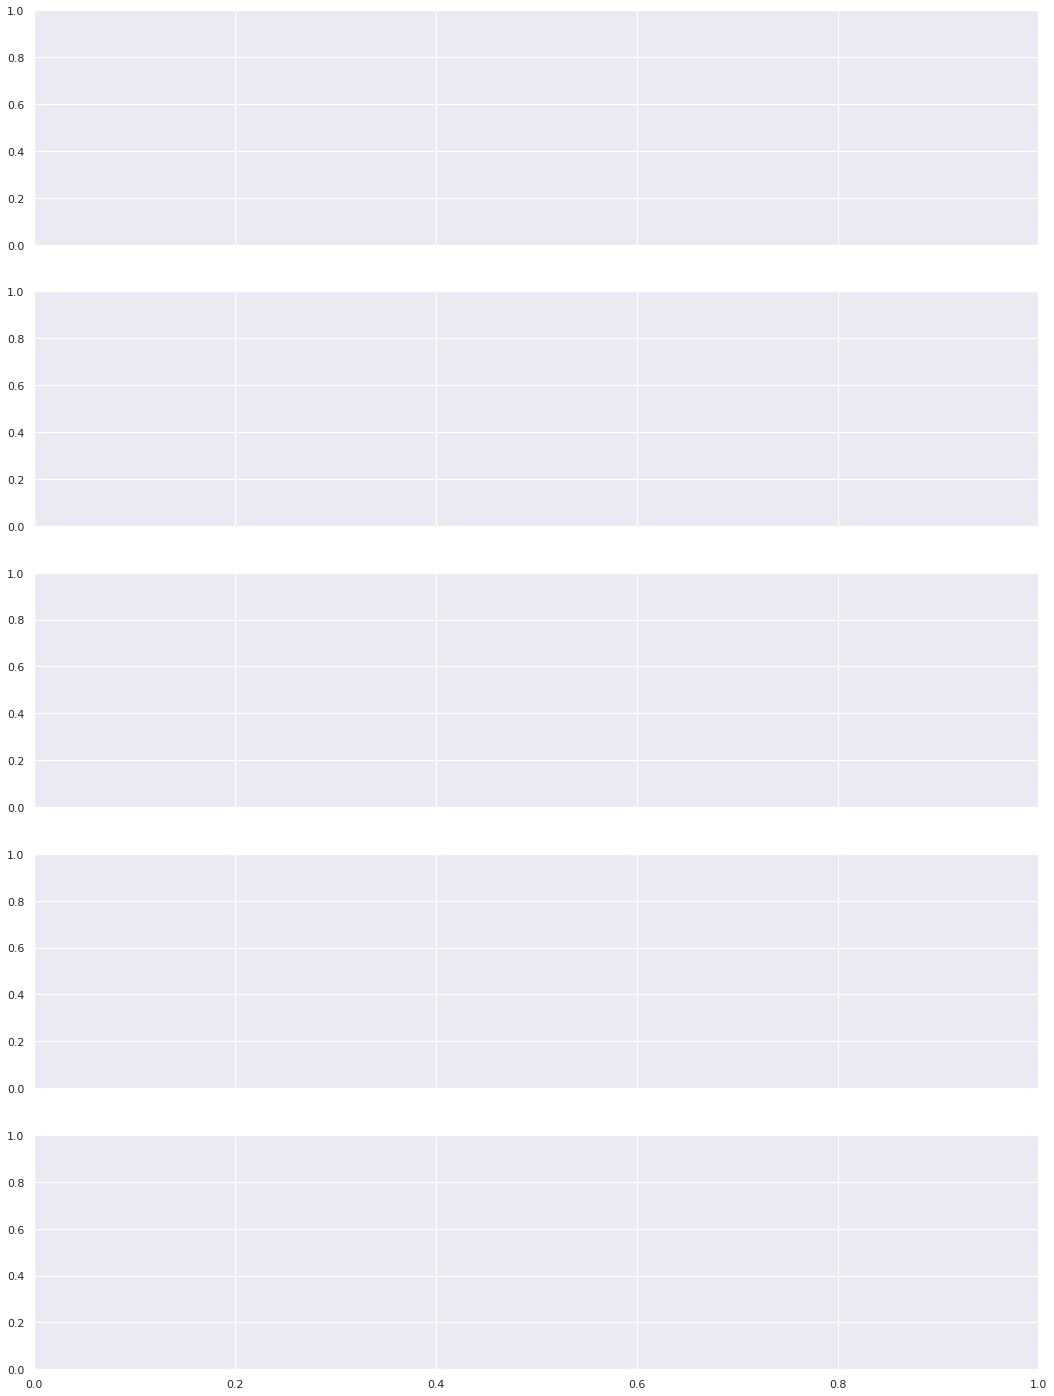

In [44]:
plot_series_by_cluster(y_pred, meteo_daily, dba_km.cluster_centers_, centers=True)

### Distribución semanal de clústers

In [25]:
weekly_cluster_distribution(y_pred, meteo_daily)

AttributeError: 'numpy.ndarray' object has no attribute 'index'